# Clasificación de deportes a partir de vídeos - RNN

## 1. Introducción

- Objetivo: Clasificación de vídeos en 5 deportes distintos usando CNN+LSTM
- Dataset: UCF50
- Arquitectura: CNN para características espaciales + LSTM para temporales

## 2. Importación de librerías

In [1]:
import os
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, TimeDistributed, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
from google.colab import drive, files


In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3. Carga y preprocesamiento de datos

In [3]:
IMG_SIZE = 112
NUM_FRAMES = 12

def extract_frames(video_path, num_frames=NUM_FRAMES):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, total_frames // num_frames)

    for i in range(num_frames):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i * step)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame = frame / 255.0
        frames.append(frame)
    cap.release()

    while len(frames) < num_frames:
        frames.append(np.zeros((IMG_SIZE, IMG_SIZE, 3)))
    return np.array(frames)


## 4. Construcción del modelo

In [4]:
def build_model(num_classes=5):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    cnn = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

    model = Sequential([
        TimeDistributed(cnn, input_shape=(NUM_FRAMES, IMG_SIZE, IMG_SIZE, 3)),
        LSTM(64),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

## 5. Entrenamiento del modelo

In [5]:
def load_data(data_dir):
    X, y, labels = [], [], sorted(os.listdir(data_dir))
    label_map = {label: idx for idx, label in enumerate(labels)}

    for label in labels:
        class_dir = os.path.join(data_dir, label)
        for video_file in os.listdir(class_dir):
            video_path = os.path.join(class_dir, video_file)
            frames = extract_frames(video_path)
            X.append(frames)
            y.append(label_map[label])

    return np.array(X), to_categorical(y), label_map

In [6]:
X_train, y_train, label_map = load_data("/content/drive/MyDrive/dataset/train")
X_test, y_test, _ = load_data("/content/drive/MyDrive/dataset/test")

model = build_model(num_classes=5)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, batch_size=4, validation_split=0.2)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
136/136 ━━━━━━━━━━━━━━━━━━━━ 324s 803ms/step - accuracy: 0.4322 - loss: 1.2911 - val_accuracy: 0.0000e+00 - val_loss: 4.4226
Epoch 2/5
136/136 ━━━━━━━━━━━━━━━━━━━━ 83s 613ms/step - accuracy: 0.3643 - loss: 1.3684 - val_accuracy: 0.0074 - val_loss: 4.9090
Epoch 3/5
136/136 ━━━━━━━━━━━━━━━━━━━━ 143s 618ms/step - accuracy: 0.3421 - loss: 1.3550 - val_accuracy: 0.0588 - val_loss: 5.5764
Epoch 4/5
136/136 ━━━━━━━━━━━━━━━━━━━━ 141s 613ms/step - accuracy: 0.5064 - loss: 1.1395 - val_accuracy: 0.0074 - val_loss: 6.0984
Epoch 5/5
136/136 ━━━━━━━━━━━━━━━━━━━━ 142s 616ms/step - accuracy: 0.5205 - loss: 1.0873 - val_accuracy: 0.0074 - val_loss: 7.0236


## 6. Evaluación

6/6 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step
📊 Reporte de Clasificación:

              precision    recall  f1-score   support

  Basketball       0.00      0.00      0.00        36
    JumpRope       0.26      0.53      0.35        36
PlayingTabla       0.86      0.83      0.85        36
 TennisSwing       0.36      0.67      0.47        36
        YoYo       0.00      0.00      0.00        36

    accuracy                           0.41       180
   macro avg       0.30      0.41      0.33       180
weighted avg       0.30      0.41      0.33       180



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/IPython/c

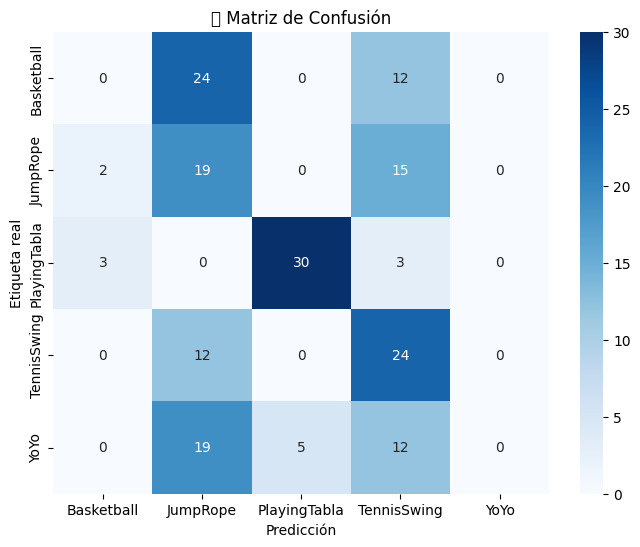

In [7]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Etiquetas de clase
labels = list(label_map.keys())

# Imprimir métricas
print("📊 Reporte de Clasificación:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="Blues")
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('🔍 Matriz de Confusión')
plt.show()

## 7.  Función de Inferencia

In [8]:
def predict_video(video_path, model, label_map):
    frames = extract_frames(video_path)
    frames = np.expand_dims(frames, axis=0)  # Batch dimension
    prediction = model.predict(frames)
    predicted_class = np.argmax(prediction)
    inv_label_map = {v: k for k, v in label_map.items()}
    return inv_label_map[predicted_class]

In [9]:
video_path = "/content/drive/MyDrive/Tennis_swing.mp4"

prediction = predict_video(video_path, model, label_map)
print("The predicted class is:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
The predicted class is: TennisSwing
